# Import Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import multiprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import tensorflow as tf
import tensorflow
from tensorflow.keras.utils import to_categorical
import pickle
import catboost as cb
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, mean_absolute_error,
                             mean_squared_error)
from sklearn.model_selection import (cross_val_score, GridSearchCV,
                                     RandomizedSearchCV, RepeatedStratifiedKFold,
                                     train_test_split)

# Set Random State

In [7]:
global rand_state
rand_state = 2023

# Utility Functions

In [48]:
def get_mean_cvs(model, X, y, fit_params=None):
    global rand_state
    cv = RepeatedStratifiedKFold(n_splits=10,
                                 n_repeats=3,
                                 random_state=rand_state)
    
    scores = cross_val_score(model, X, y,
                             scoring='neg_log_loss',
                             cv=cv,
                             n_jobs=-1,
                             error_score='raise', 
                             fit_params=fit_params)
    
    print(f'Cross Validation Negative Logloss Score: {scores.mean():.3f} ({scores.std():.3f})')
    
    return scores


def evaluate_model(y_true, y_pred):
    """Prints a classification report and plots a confusion matrix."""
    labels = ['High Shares', 'Average Shares', 'Low Shares']

    print(classification_report(y_true=y_true,
                                y_pred=y_pred,
                                target_names=labels, 
                                digits=3))

    cm = confusion_matrix(y_true=y_true,
                          y_pred=y_pred,
                          labels=labels)

    plt.imshow(cm, cmap=plt.cm.Blues)
    threshold = cm.min() + ((cm.max() - cm.min()) / 2)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]): 
            plt.text(x=j, y=i, s=cm[i,j], 
                      color='w' if cm[i,j] > threshold else 'black',
                      fontsize=16, ha='center', va='center')

    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    plt.tight_layout()

def get_best_params(model, grid, X, y, is_iterate_all):
    # Estimates model performance
    cv = RepeatedStratifiedKFold(n_splits=10,
                                 n_repeats=3, 
                                 random_state=rand_state)

    if is_iterate_all:
        # Tries all combinations of hyperparameters specified in grid to
        # get best parameters
        scv = GridSearchCV(estimator=model,
                           param_grid=grid,
                           n_jobs=-1,
                           cv=cv,
                           scoring='accuracy',
                           error_score=0)
    else:
        scv = RandomizedSearchCV(estimator=model,
                                 param_distributions=grid,
                                 n_iter=10,
                                 n_jobs=-1,
                                 cv=None, 
                                 scoring='accuracy', 
                                 random_state=rand_state)
    
    grid_result = scv.fit(X, y)
    
    # Results summary
    print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}')
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print(f'{mean} ({stdev}) with: {param}')
    print("Best Parameters: " +  str(grid_result.best_params_))
        
    return grid_result

# Load Dataset

In [9]:
X_train = pd.read_csv('./dataset/SmartLocal/X_train.csv')
y_train = pd.read_csv('./dataset/SmartLocal/y_train.csv').to_numpy().ravel()

X_test = pd.read_csv('./dataset/SmartLocal/X_test.csv')
y_test = pd.read_csv('./dataset/SmartLocal/y_test.csv').to_numpy().ravel()

In [80]:
X_train_tree = pd.read_csv('./dataset/SmartLocal/X_train_tree.csv')
y_train_tree = pd.read_csv('./dataset/SmartLocal/y_train_tree.csv').to_numpy().ravel()

X_test_tree = pd.read_csv('./dataset/SmartLocal/X_test_tree.csv')
y_test_tree = pd.read_csv('./dataset/SmartLocal/y_test_tree.csv').to_numpy().ravel()

In [83]:
categorical_cols = X_train_tree.select_dtypes(include='O').keys().tolist()

label_encoder = LabelEncoder()

for col in categorical_cols:
    X_train_tree[col] = label_encoder.fit_transform(X_train_tree[col].astype(str))
    X_test_tree[col] = label_encoder.fit_transform(X_test_tree[col].astype(str))

# Scaling Data

In [10]:
# Gradient descent and distance-based algorithms require feature scaling while tree-based algorithms do not.
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Probabilistic

## Logistic Regression

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 2023, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Cross Validation Accuracy Score: 0.476 (0.021)
                precision    recall  f1-score   support

   High Shares      0.420     0.325     0.367       283
Average Shares      0.516     0.580     0.546       245
    Low Shares      0.505     0.568     0.535       271

      accuracy                          0.486       799
     macro avg      0.480     0.491     0.482       799
  weighted avg      0.478     0.486     0.479       799



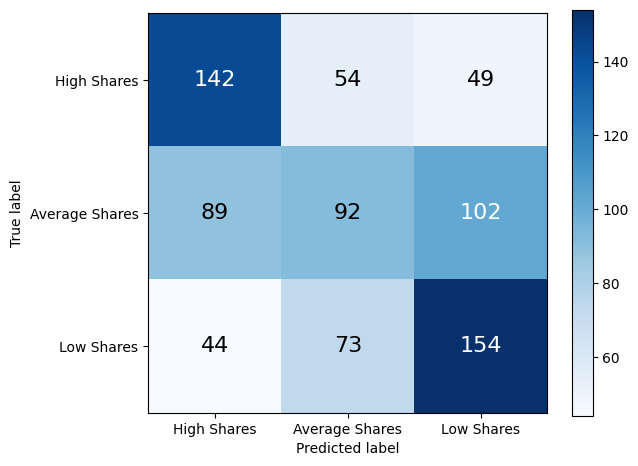

In [11]:
lr_base_model = LogisticRegression(max_iter=1000, random_state=rand_state)
print(lr_base_model.get_params())

get_mean_cvs(lr_base_model, X_train_scaled, y_train)

lr_base_model.fit(X_train_scaled, y_train)
y_pred_cb_base = lr_base_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_cb_base)

{'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 2023, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Cross Validation Accuracy Score: 0.476 (0.022)
                precision    recall  f1-score   support

   High Shares      0.399     0.300     0.343       283
Average Shares      0.513     0.584     0.546       245
    Low Shares      0.498     0.565     0.529       271

      accuracy                          0.477       799
     macro avg      0.470     0.483     0.473       799
  weighted avg      0.468     0.477     0.468       799



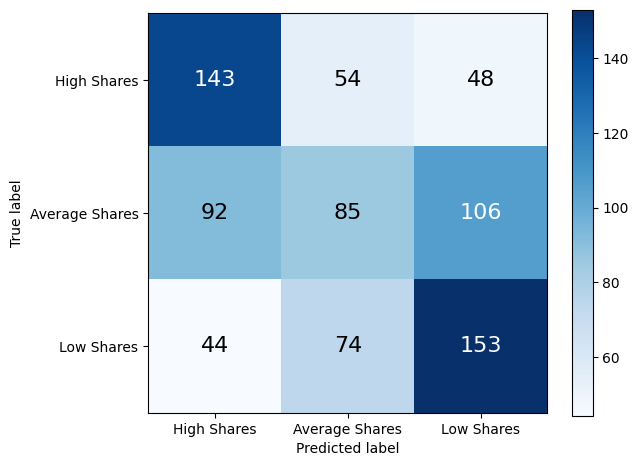

In [12]:
lr_GS = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=rand_state), 
    {
        'C': [0.1, 1, 10], 
        'solver': ['newton-cg', 'lbfgs', 'liblinear'], 
    }, 
    n_jobs=multiprocessing.cpu_count())

lr_GS = lr_GS.fit(X_train_scaled, y_train)

lr_best_model = lr_GS.best_estimator_
print(lr_best_model.get_params())

get_mean_cvs(lr_best_model, X_train_scaled, y_train)

lr_best_model.fit(X_train_scaled, y_train)
y_pred_lr_best = lr_best_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_lr_best)

In [13]:
pickle.dump(lr_best_model, open('./dataset/Model/lr_best_model.pkl', 'wb'))

## Naive Bayes

{'priors': None, 'var_smoothing': 1e-09}
Cross Validation Accuracy Score: 0.367 (0.013)
                precision    recall  f1-score   support

   High Shares      0.000     0.000     0.000       283
Average Shares      0.324     0.980     0.487       245
    Low Shares      0.569     0.122     0.201       271

      accuracy                          0.342       799
     macro avg      0.298     0.367     0.229       799
  weighted avg      0.292     0.342     0.217       799



/Users/PoYan1/miniconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/PoYan1/miniconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/PoYan1/miniconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


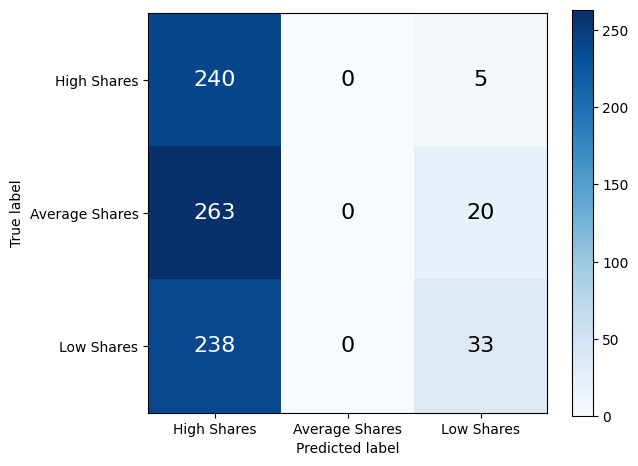

In [9]:
nb_base_model = GaussianNB()
print(nb_base_model.get_params())

get_mean_cvs(nb_base_model, X_train_scaled, y_train)

nb_base_model.fit(X_train_scaled, y_train)
y_pred_nb_base = nb_base_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_nb_base)

{'priors': None, 'var_smoothing': 0.01}
Cross Validation Accuracy Score: 0.453 (0.022)
                precision    recall  f1-score   support

   High Shares      0.387     0.272     0.320       283
Average Shares      0.503     0.592     0.544       245
    Low Shares      0.487     0.561     0.521       271

      accuracy                          0.468       799
     macro avg      0.459     0.475     0.462       799
  weighted avg      0.457     0.468     0.457       799



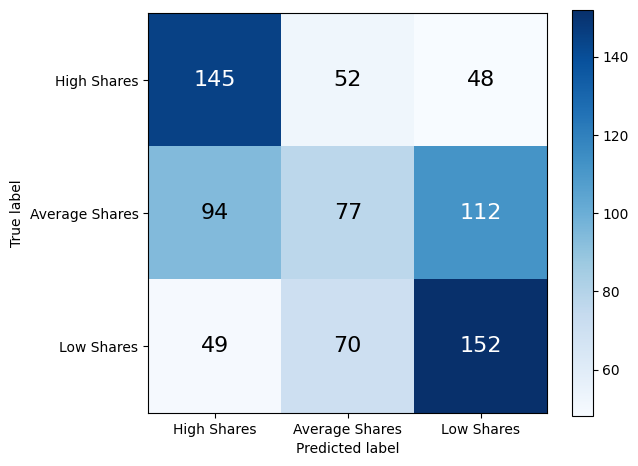

In [10]:
nb_GS = GridSearchCV(
    GaussianNB(), 
    {
        'var_smoothing': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2], 
    }, 
    n_jobs=multiprocessing.cpu_count())

nb_GS = nb_GS.fit(X_train_scaled, y_train)

nb_best_model = nb_GS.best_estimator_
print(nb_best_model.get_params())

get_mean_cvs(nb_best_model, X_train_scaled, y_train)

nb_best_model.fit(X_train_scaled, y_train)
y_pred_nb_best = nb_best_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_lr_best)

In [11]:
pickle.dump(nb_best_model, open('./dataset/Model/nb_best_model.pkl', 'wb'))

# Instance Based

## K-Nearest Neighbours

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Cross Validation Accuracy Score: 0.405 (0.017)
                precision    recall  f1-score   support

   High Shares      0.401     0.516     0.451       283
Average Shares      0.463     0.465     0.464       245
    Low Shares      0.460     0.321     0.378       271

      accuracy                          0.434       799
     macro avg      0.442     0.434     0.431       799
  weighted avg      0.440     0.434     0.431       799



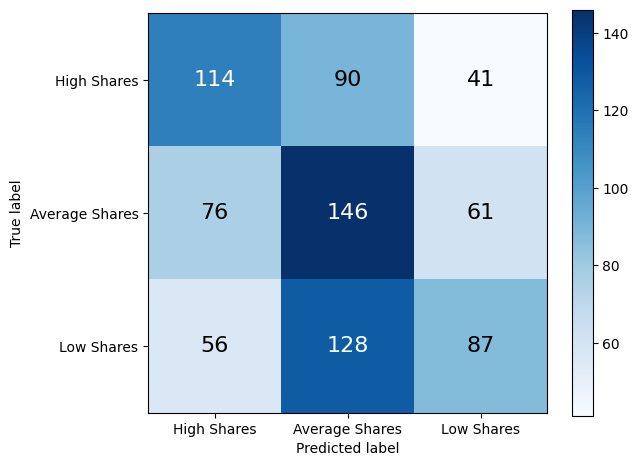

In [12]:
knn_base_model = KNeighborsClassifier()
print(knn_base_model.get_params())

get_mean_cvs(knn_base_model, X_train_scaled, y_train)

knn_base_model.fit(X_train_scaled, y_train)
y_pred_cb_base = knn_base_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_cb_base)

{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 11, 'p': 3, 'weights': 'distance'}
Cross Validation Accuracy Score: 0.426 (0.024)
                precision    recall  f1-score   support

   High Shares      0.434     0.438     0.436       283
Average Shares      0.468     0.478     0.473       245
    Low Shares      0.494     0.480     0.487       271

      accuracy                          0.464       799
     macro avg      0.465     0.465     0.465       799
  weighted avg      0.465     0.464     0.464       799



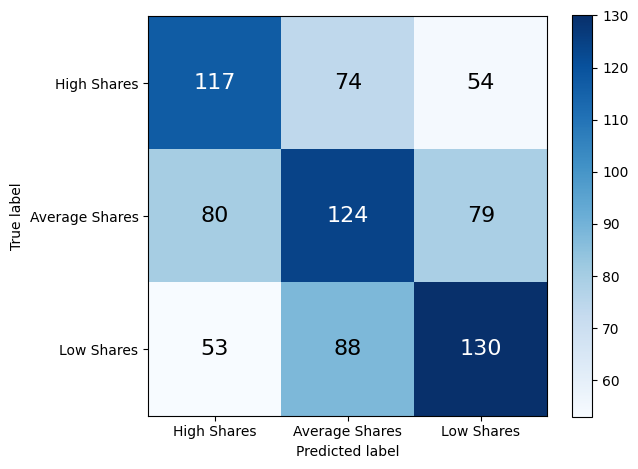

In [13]:
knn_GS = GridSearchCV(
    KNeighborsClassifier(), 
    {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [10, 20, 30],
        'p': [1, 2, 3]
    }, 
    n_jobs=multiprocessing.cpu_count())

knn_GS = knn_GS.fit(X_train_scaled, y_train)

knn_best_model = knn_GS.best_estimator_
print(knn_best_model.get_params())

get_mean_cvs(knn_best_model, X_train_scaled, y_train)

knn_best_model.fit(X_train_scaled, y_train)
y_pred_knn_best = knn_best_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_knn_best)

In [14]:
pickle.dump(knn_best_model, open('./dataset/Model/knn_best_model.pkl', 'wb'))

## Support Vector Machine

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Cross Validation Accuracy Score: 0.474 (0.028)
                precision    recall  f1-score   support

   High Shares      0.392     0.353     0.372       283
Average Shares      0.536     0.571     0.553       245
    Low Shares      0.512     0.535     0.523       271

      accuracy                          0.482       799
     macro avg      0.480     0.487     0.483       799
  weighted avg      0.477     0.482     0.479       799



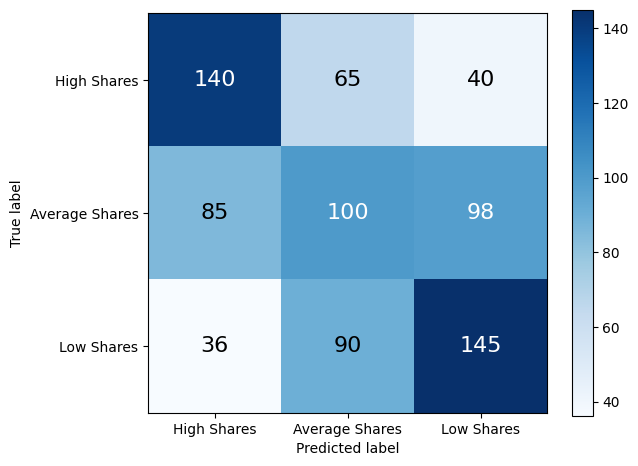

In [15]:
svm_base_model = SVC()
print(svm_base_model.get_params())

get_mean_cvs(svm_base_model, X_train_scaled, y_train)

svm_base_model.fit(X_train_scaled, y_train)
y_pred_cb_base = svm_base_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_cb_base)

{'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Cross Validation Accuracy Score: 0.480 (0.023)
                precision    recall  f1-score   support

   High Shares      0.404     0.290     0.337       283
Average Shares      0.509     0.580     0.542       245
    Low Shares      0.492     0.576     0.531       271

      accuracy                          0.476       799
     macro avg      0.468     0.482     0.470       799
  weighted avg      0.466     0.476     0.466       799



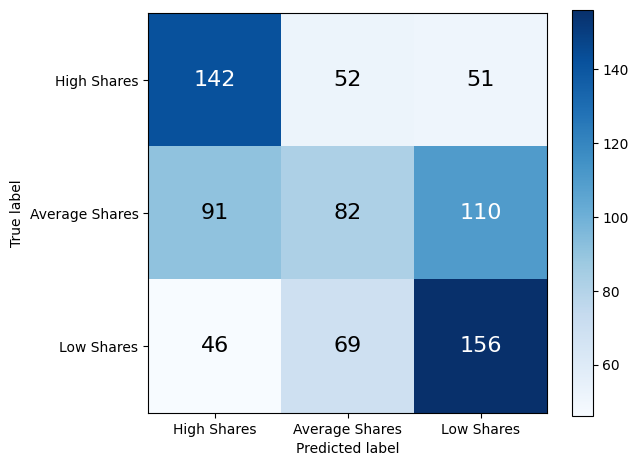

In [16]:
svm_GS = GridSearchCV(
    SVC(), 
    {
        'C': [0.1, 1, 10], 
        'kernel': ['linear', 'rbf'], 
        'gamma': ['scale', 'auto', 0.1, 1]
    }, 
    n_jobs=multiprocessing.cpu_count())

svm_GS = svm_GS.fit(X_train_scaled, y_train)

svm_best_model = svm_GS.best_estimator_
print(svm_best_model.get_params())

get_mean_cvs(svm_best_model, X_train_scaled, y_train)

svm_best_model.fit(X_train_scaled, y_train)
y_pred_svm_best = svm_best_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_svm_best)

In [17]:
pickle.dump(svm_best_model, open('./dataset/Model/svm_best_model.pkl', 'wb'))

# Tree Based

## Random Forest

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 2023, 'verbose': 0, 'warm_start': False}
Cross Validation Accuracy Score: 0.478 (0.025)
                precision    recall  f1-score   support

   High Shares      0.394     0.346     0.368       283
Average Shares      0.496     0.547     0.520       245
    Low Shares      0.511     0.528     0.519       271

      accuracy                          0.469       799
     macro avg      0.467     0.474     0.469       799
  weighted avg      0.465     0.469     0.466       799



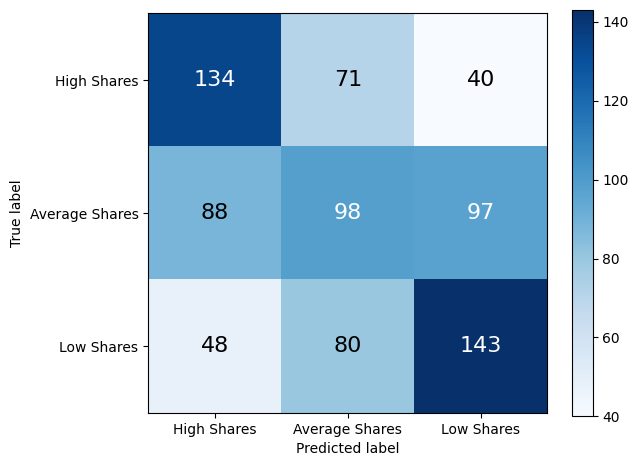

In [16]:
rf_base_model = RandomForestClassifier(
    random_state=rand_state, 
)
print(rf_base_model.get_params())

get_mean_cvs(rf_base_model, X_train, y_train)

rf_base_model.fit(X_train, y_train)
y_pred_cb_base = rf_base_model.predict(X_test)
evaluate_model(y_test, y_pred_cb_base)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, random_state=2023)
Cross Validation Accuracy Score: 0.487 (0.028)
                precision    recall  f1-score   support

   High Shares      0.350     0.265     0.302       283
Average Shares      0.486     0.547     0.514       245
    Low Shares      0.489     0.557     0.521       271

      accuracy                          0.451       799
     macro avg      0.442     0.456     0.446       799
  weighted avg      0.439     0.451     0.441       799



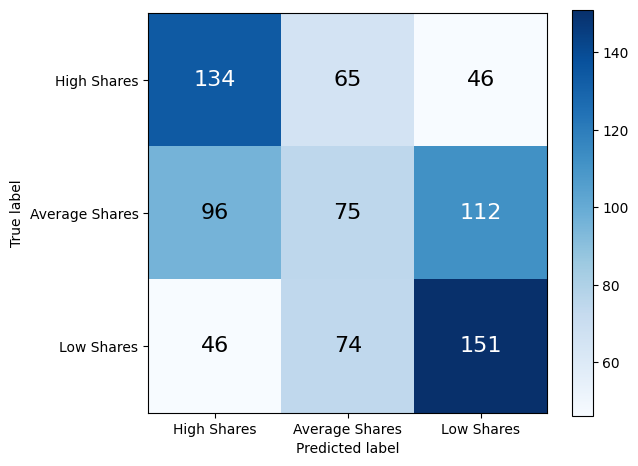

In [17]:
rf_GS = GridSearchCV(
    RandomForestClassifier(random_state=rand_state), 
    {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }, 
    n_jobs=multiprocessing.cpu_count())

rf_GS = rf_GS.fit(X_train, y_train)

rf_best_model = rf_GS.best_estimator_
print(rf_best_model)

get_mean_cvs(rf_best_model, X_train, y_train)

rf_best_model.fit(X_train, y_train)
y_pred_rf_best = rf_best_model.predict(X_test)
evaluate_model(y_test, y_pred_rf_best)

In [20]:
pickle.dump(rf_best_model, open('./dataset/Model/rf_best_model.pkl', 'wb'))

## CatBoost

{'verbose': False, 'allow_writing_files': False, 'random_state': 2023, 'objective': 'MultiClass', 'cat_features': ['category', 'subcategory1', 'author', 'author_category']}
Cross Validation Accuracy Score: 0.482 (0.025)
                precision    recall  f1-score   support

   High Shares      0.382     0.325     0.351       283
Average Shares      0.513     0.555     0.533       245
    Low Shares      0.498     0.539     0.518       271

      accuracy                          0.468       799
     macro avg      0.464     0.473     0.467       799
  weighted avg      0.462     0.468     0.464       799



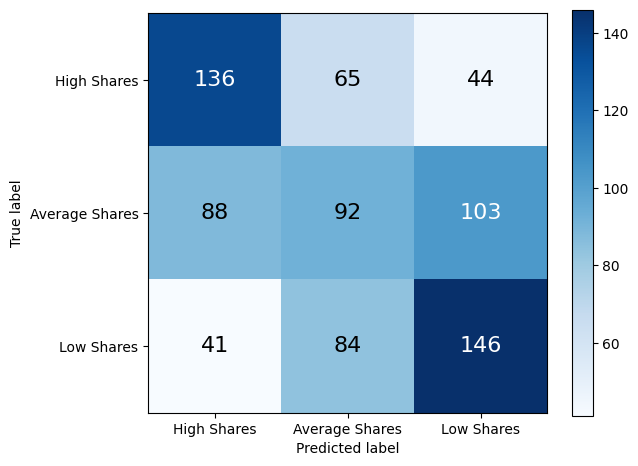

In [41]:
cb_base_model = cb.CatBoostClassifier(
    objective='MultiClass',
    cat_features=categorical_cols,
    allow_writing_files=False,
    random_state=rand_state,
    verbose=False
)
print(cb_base_model.get_params())

get_mean_cvs(cb_base_model, X_train_tree, y_train_tree)

cb_base_model.fit(X_train_tree, y_train_tree, verbose=False)
y_pred_cb_base = cb_base_model.predict(X_test_tree)
evaluate_model(y_test_tree, y_pred_cb_base)

{'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 3, 'verbose': False, 'n_estimators': 60, 'random_state': 2023, 'objective': 'MultiClass', 'cat_features': ['category', 'subcategory1', 'author', 'author_category']}
Cross Validation Accuracy Score: 0.492 (0.023)
                precision    recall  f1-score   support

   High Shares      0.403     0.258     0.315       283
Average Shares      0.474     0.567     0.517       245
    Low Shares      0.492     0.590     0.537       271

      accuracy                          0.466       799
     macro avg      0.457     0.472     0.456       799
  weighted avg      0.455     0.466     0.452       799



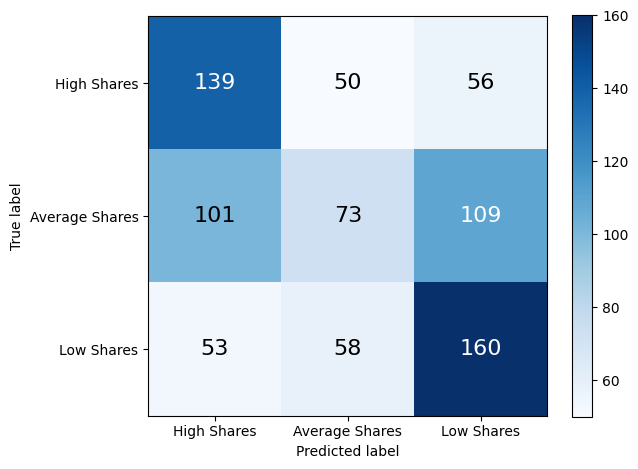

In [42]:
cb_GS = GridSearchCV(
    cb.CatBoostClassifier(objective='MultiClass', cat_features=categorical_cols, random_state=rand_state, verbose=False), 
    {
        'depth': [2, 5, 10],
        'n_estimators': [60, 100, 140],
        'learning_rate': [0.1, 0.01],
        'l2_leaf_reg': [1, 3, 5],
    }, 
    n_jobs=multiprocessing.cpu_count())

cb_GS = cb_GS.fit(X_train_tree, y_train_tree)

cb_best_model = cb_GS.best_estimator_
print(cb_best_model.get_params())

get_mean_cvs(cb_best_model, X_train_tree, y_train_tree)

cb_best_model.fit(X_train_tree, y_train_tree)
y_pred_cb_best = cb_best_model.predict(X_test_tree)
evaluate_model(y_test_tree, y_pred_cb_best)

In [43]:
pickle.dump(cb_best_model, open('./dataset/Model/cb_best_model.pkl', 'wb'))

## LightGBM

In [85]:
get_mean_cvs(lgb_base_model, X_train_tree, y_train_tree, fit_params={'categorical_feature': categorical_cols})

Cross Validation Negative Logloss Score: -1.078 (0.041)


array([-1.1584636 , -1.05946554, -1.08543459, -1.09431197, -1.00725442,
       -1.04137276, -1.05291132, -1.13316295, -1.05050033, -1.08441368,
       -1.10540479, -1.0514163 , -1.1009465 , -1.06632005, -1.00455825,
       -1.14048462, -1.10961833, -1.07264546, -1.06982447, -1.07326204,
       -1.10177405, -1.04582013, -1.05817459, -0.98613439, -1.1300159 ,
       -1.09083956, -1.10681101, -1.13187582, -1.08700763, -1.03198538])

In [84]:
lgb_base_model.fit(X_train_tree, y_train_tree, categorical_feature=categorical_cols)

C:\Users\user\anaconda3\envs\is4242\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\user\anaconda3\envs\is4242\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\user\anaconda3\envs\is4242\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


LGBMClassifier(categorical_feature=['category', 'subcategory1', 'author',
                                    'author_category'],
               objective='accuracy', random_state=2023)

LGBMClassifier(categorical_feature=['category', 'subcategory1', 'author',
                                    'author_category'],
               objective='accuracy', random_state=2023)
Cross Validation Negative Logloss Score: -1.078 (0.041)


C:\Users\user\anaconda3\envs\is4242\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\user\anaconda3\envs\is4242\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\user\anaconda3\envs\is4242\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


                precision    recall  f1-score   support

   High Shares      0.397     0.293     0.337       283
Average Shares      0.432     0.388     0.409       245
    Low Shares      0.451     0.616     0.521       271

      accuracy                          0.432       799
     macro avg      0.427     0.432     0.422       799
  weighted avg      0.426     0.432     0.422       799



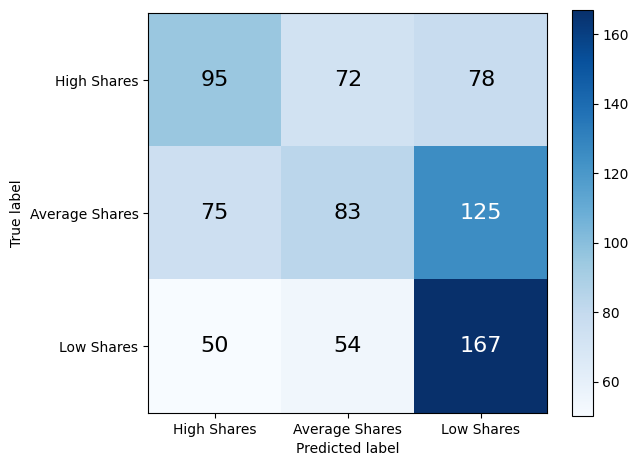

In [86]:
lgb_base_model = lgb.LGBMClassifier(
    objective='accuracy',
    categorical_feature=categorical_cols,
    random_state=rand_state
)
print(lgb_base_model)

get_mean_cvs(lgb_base_model, X_train_tree, y_train_tree, fit_params={'categorical_feature': categorical_cols})

lgb_base_model.fit(X_train_tree, y_train_tree, categorical_feature=categorical_cols)
y_pred_lgb_base = lgb_base_model.predict(X_test_tree)
evaluate_model(y_test_tree, y_pred_lgb_base)

C:\Users\user\anaconda3\envs\is4242\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\user\anaconda3\envs\is4242\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\user\anaconda3\envs\is4242\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


LGBMClassifier(categorical_feature=['category', 'subcategory1', 'author',
                                    'author_category'],
               learning_rate=0.01, max_depth=10, n_estimators=140,
               num_leaves=10, objective='accuracy', random_state=2023,
               subsample=0.5)
Cross Validation Negative Logloss Score: -1.005 (0.018)


C:\Users\user\anaconda3\envs\is4242\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\user\anaconda3\envs\is4242\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\user\anaconda3\envs\is4242\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


                precision    recall  f1-score   support

   High Shares      0.355     0.194     0.251       283
Average Shares      0.419     0.420     0.420       245
    Low Shares      0.432     0.635     0.514       271

      accuracy                          0.413       799
     macro avg      0.402     0.416     0.395       799
  weighted avg      0.401     0.413     0.392       799



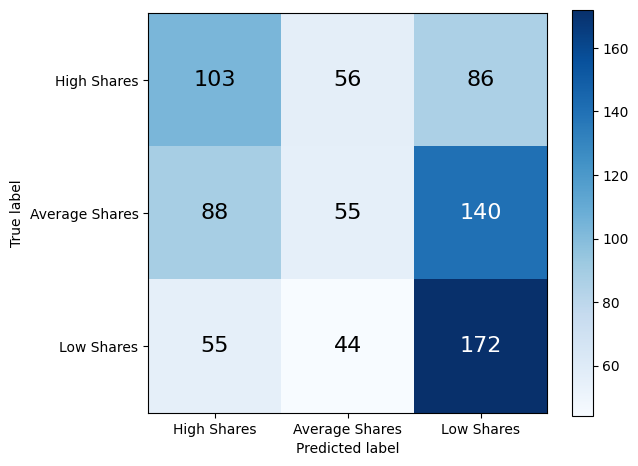

In [90]:
lgb_GS = GridSearchCV(
    lgb.LGBMClassifier(objective='accuracy', categorical_feature=categorical_cols, random_state=rand_state), 
    {
        'max_depth': [2, 5, 10],
        'n_estimators': [60, 100, 140],
        'learning_rate': [0.1, 0.01],
        'num_leaves': [10, 20, 30],
        'subsample': [0.5, 0.7, 0.9], 
    }, 
    n_jobs=multiprocessing.cpu_count())

lgb_GS = lgb_GS.fit(X_train_tree, y_train_tree, categorical_feature=categorical_cols)

lgb_best_model = lgb_GS.best_estimator_
print(lgb_best_model)

get_mean_cvs(lgb_best_model, X_train_tree, y_train_tree, fit_params={'categorical_feature': categorical_cols})

lgb_best_model.fit(X_train_tree, y_train_tree, categorical_feature=categorical_cols)
y_pred_lgb_best = lgb_best_model.predict(X_test_tree)
evaluate_model(y_test_tree, y_pred_lgb_best)

In [91]:
pickle.dump(lgb_best_model, open('./dataset/Model/lgb_best_model.pkl', 'wb'))

## Adaboost

AdaBoostClassifier(random_state=2023)
Cross Validation Accuracy Score: 0.469 (0.026)
                precision    recall  f1-score   support

   High Shares      0.398     0.290     0.335       283
Average Shares      0.481     0.563     0.519       245
    Low Shares      0.493     0.557     0.523       271

      accuracy                          0.464       799
     macro avg      0.457     0.470     0.459       799
  weighted avg      0.456     0.464     0.455       799



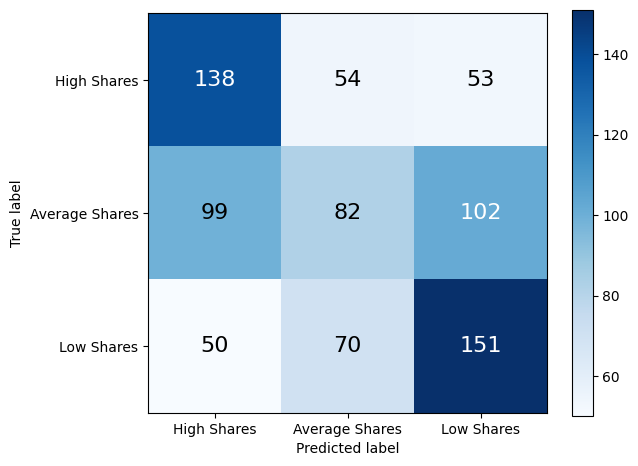

In [27]:
ada_base_model = AdaBoostClassifier(
    random_state=rand_state
)
print(ada_base_model)

get_mean_cvs(ada_base_model, X_train, y_train)

ada_base_model.fit(X_train, y_train)
y_pred_lgb_base = ada_base_model.predict(X_test)
evaluate_model(y_test, y_pred_lgb_base)

AdaBoostClassifier(learning_rate=0.1, n_estimators=150, random_state=2023)
Cross Validation Accuracy Score: 0.483 (0.027)
                precision    recall  f1-score   support

   High Shares      0.380     0.258     0.307       283
Average Shares      0.509     0.571     0.538       245
    Low Shares      0.467     0.572     0.514       271

      accuracy                          0.461       799
     macro avg      0.452     0.467     0.453       799
  weighted avg      0.449     0.461     0.448       799



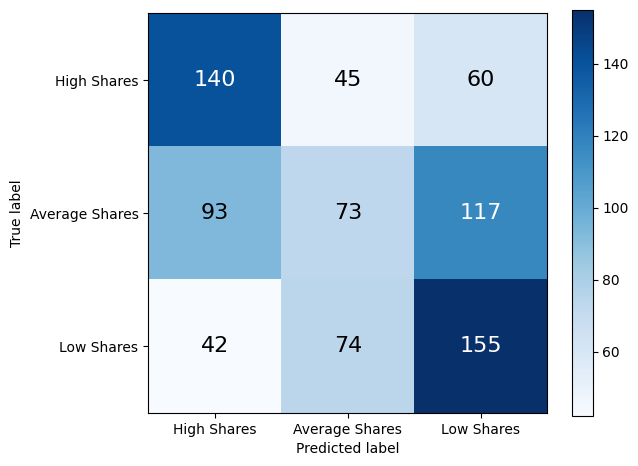

In [28]:
ada_GS = GridSearchCV(
    AdaBoostClassifier(random_state=rand_state), 
    {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 1.0],
        'algorithm': ['SAMME', 'SAMME.R']
    }, 
    n_jobs=multiprocessing.cpu_count())

ada_GS = ada_GS.fit(X_train, y_train)

ada_best_model = ada_GS.best_estimator_
print(ada_best_model)

get_mean_cvs(ada_best_model, X_train, y_train)

lgb_base_model.fit(X_train, y_train)
y_pred_ada_best = ada_best_model.predict(X_test)
evaluate_model(y_test, y_pred_ada_best)

In [29]:
pickle.dump(ada_best_model, open('./dataset/Model/ada_best_model.pkl', 'wb'))

# Deep Learning

In [149]:
# Reshape X_train and X_test
X_train_map = np.reshape(X_train_scaled.values, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_map = np.reshape(X_test_scaled.values, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Map y_train and y_test
mapper = {'Low Shares': 0, 'Average Shares': 1, 'High Shares': 2}
rev_mapper = {value: key for key, value in mapper.items()}
y_train_map = np.vectorize(lambda x: mapper[x])(y_train)
y_test_map = np.vectorize(lambda x: mapper[x])(y_test)

# One-hot encode target variables
y_train_encode = to_categorical(y_train_map)
y_test_encode = to_categorical(y_test_map)

## Convolutional Neural Network

In [150]:
tf.keras.utils.set_random_seed(1)

# Build the model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train_map.shape[1], X_train_map.shape[2])))
cnn_model.add(MaxPooling1D(pool_size=2, padding="same"))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv1D(64, kernel_size=2,padding="same", activation="linear"))
cnn_model.add(MaxPooling1D(pool_size=2, padding="same"))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv1D(32, kernel_size=2,padding="same", activation="linear"))
cnn_model.add(MaxPooling1D(pool_size=2, padding="same"))
cnn_model.add(Dropout(0.2))
cnn_model.add(Flatten())
cnn_model.add(Dense(units=3, activation='softmax'))

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model.fit(X_train_map, y_train_encode, epochs=25, batch_size=32, validation_data=(X_test_map, y_test_encode), workers=multiprocessing.cpu_count())


Epoch 1/25
100/100 [==============================] - 4s 33ms/step - loss: 1.0935 - accuracy: 0.3818 - val_loss: 1.0715 - val_accuracy: 0.3930
Epoch 2/25
100/100 [==============================] - 2s 22ms/step - loss: 1.0646 - accuracy: 0.4215 - val_loss: 1.0618 - val_accuracy: 0.4230
Epoch 3/25
100/100 [==============================] - 2s 21ms/step - loss: 1.0514 - accuracy: 0.4313 - val_loss: 1.0614 - val_accuracy: 0.4380
Epoch 4/25
100/100 [==============================] - 2s 21ms/step - loss: 1.0420 - accuracy: 0.4428 - val_loss: 1.0456 - val_accuracy: 0.4318
Epoch 5/25
100/100 [==============================] - 2s 22ms/step - loss: 1.0387 - accuracy: 0.4519 - val_loss: 1.0513 - val_accuracy: 0.4268
Epoch 6/25
100/100 [==============================] - 2s 21ms/step - loss: 1.0249 - accuracy: 0.4729 - val_loss: 1.0376 - val_accuracy: 0.4531
Epoch 7/25
100/100 [==============================] - 2s 21ms/step - loss: 1.0224 - accuracy: 0.4682 - val_loss: 1.0411 - val_accuracy: 0.4293

25/25 [==============================] - 0s 5ms/step
                precision    recall  f1-score   support

   High Shares      0.361     0.410     0.384       283
Average Shares      0.494     0.478     0.485       245
    Low Shares      0.523     0.465     0.492       271

      accuracy                          0.449       799
     macro avg      0.459     0.451     0.454       799
  weighted avg      0.457     0.449     0.452       799



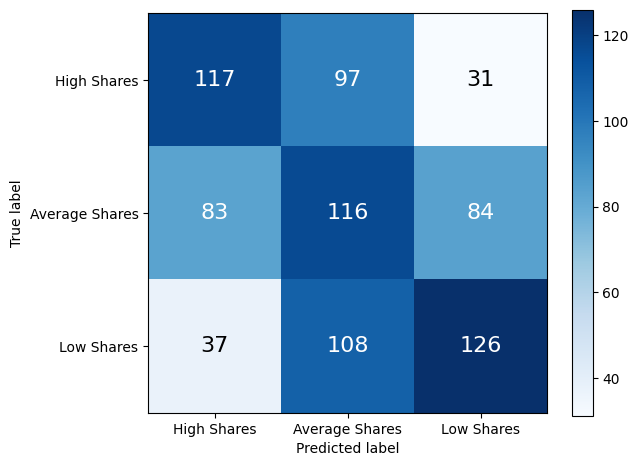

In [151]:
y_pred_cnn = cnn_model.predict(X_test_map)
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)
y_pred_cnn = np.vectorize(lambda x: rev_mapper[x])(y_pred_cnn)

y_test_cnn = np.argmax(y_test_encode, axis=1)
y_test_cnn = np.vectorize(lambda x: rev_mapper[x])(y_test_cnn)

evaluate_model(y_test_cnn, y_pred_cnn)